If the service still fails to start, please refer to PFRED Docker README <a>https://github.com/pddfred/pfred-docker#</a>

In [ ]:
Maybe you need to

# 1. Install the EPEL repository
yum install -y epel-release

# 2. Refresh and install R
yum install -y R




In [54]:
import pandas as pd
from notebooks.consts import *

all_data = pd.read_csv(str(UPDATED_CSV), low_memory=False)
all_data[CELL_LINE_ORGANISM] = 'human'
from notebooks.notebook_utils import log_correction, get_unique_human_genes

# Create a new column with transformed inhibition values on a negative log scale
log_correction(all_data, correction=5)  # to avoid log 0
from notebooks.notebook_utils import read_cached_gene_to_data
from tauso.new_model.data_handling import get_populated_df_with_structure_features

genes_u = get_unique_human_genes(all_data)
gene_to_data = read_cached_gene_to_data(genes_u)
all_data_human_gene = get_populated_df_with_structure_features(all_data, genes_u, gene_to_data)
all_data_human_gene.columns

Prepared 32823 sequences.


In [71]:
from notebooks.consts import UPDATED_CSV, CANONICAL_GENE
import pandas as pd
import subprocess
import os
import re

# --- CONFIGURATION ---
CONTAINER_NAME = "pfred"
TEMP_HOST_DIR = os.path.abspath("./pfred_temp_io")
os.makedirs(TEMP_HOST_DIR, exist_ok=True)
OUTPUT_SCORED_CSV = "data_scored_pfred_final.csv"

# --- CORE FUNCTION: BATCH SCORING ---
def score_with_pfred_batch(input_df):
    """
    Runs PFRED on a batch of unique sequences.
    Input: DataFrame with ['name', 'seq']
    Output: DataFrame with ['seq', 'SVMpred', 'PLSpred']
    """
    if input_df.empty: return pd.DataFrame()

    local_in = os.path.join(TEMP_HOST_DIR, "pfred_input.csv")
    local_out = os.path.join(TEMP_HOST_DIR, "pfred_results.csv")
    remote_dir = "/home/pfred/scratch"
    remote_in = "pfred_input.csv"

    # Cleanup previous run
    if os.path.exists(local_out): os.remove(local_out)

    # 1. Format for PFRED: [Seq, ID, DummyScore]
    #    The dummy score (1.0) ensures the legacy script processes the line.
    export_df = pd.DataFrame({
        'col0': input_df['seq'],
        'col1': input_df['name'],
        'col2': 1.0
    })
    export_df.to_csv(local_in, index=False, header=["Seq", "ID", "Score"])

    try:
        # 2. Transfer to Docker
        subprocess.run(["docker", "exec", CONTAINER_NAME, "mkdir", "-p", remote_dir], check=False)
        subprocess.run(["docker", "cp", local_in, f"{CONTAINER_NAME}:{remote_dir}/{remote_in}"], check=True)

        # 3. Execute PFRED (Predict Mode)
        #    Note: We pipe input_params.txt to handle the interactive prompts of the legacy script
        cmd = f"""
        cd {remote_dir}
        tr -d '\\r' < {remote_in} > {remote_in}.tmp && mv {remote_in}.tmp {remote_in}
        echo -e "15\\n21\\n100\\n1000\\n12" > input_params.txt

        export PATH=/home/pfred/bin/R2.6.0/bin:$PATH
        export R_HOME=/home/pfred/bin/R2.6.0/lib64/R
        export PYTHONPATH=/usr/lib64/python2.6/site-packages:$PYTHONPATH

        python2 /home/pfred/scripts/pfred/antisense_predictor.py \
            AOBase \
            /home/pfred/scripts/pfred/AOBase_542seq_cleaned_modelBuilding_Jan2009_15_21_noOutliers.csv \
            c_a_thermo \
            predict \
            ./{remote_in} \
            < input_params.txt > run.log 2>&1

        ls -t *.csv | grep -v "{remote_in}" | head -n 1
        """

        result = subprocess.run(
            ["docker", "exec", CONTAINER_NAME, "/bin/bash", "-c", cmd],
            capture_output=True, text=True
        )

        target_file = result.stdout.strip()
        if not target_file: return pd.DataFrame()

        # 4. Retrieve Results
        subprocess.run(["docker", "cp", f"{CONTAINER_NAME}:{remote_dir}/{target_file}", local_out], check=True)
        # Cleanup remote to keep container light
        subprocess.run(["docker", "exec", CONTAINER_NAME, "rm", "-rf", remote_dir], check=False)

        if os.path.exists(local_out):
            return pd.read_csv(local_out)
        return pd.DataFrame()

    except Exception as e:
        print(f"[ERROR] Docker execution failed: {e}")
        return pd.DataFrame()

# ==========================================
# MAIN EXECUTION
# ==========================================
print("\n>>> STARTING PFRED ANNOTATION PIPELINE...")

if os.path.exists(UPDATED_CSV):
    full_df = pd.read_csv(UPDATED_CSV, low_memory=False)
    print(f"   Loaded {len(full_df)} rows from '{UPDATED_CSV}'.")

    # 1. Standardize Sequences for Matching
    #    We create a temporary 'clean_seq' column to handle U/T and non-ACTG chars.
    print("   Standardizing sequences...")
    full_df['clean_seq'] = full_df['Sequence'].astype(str).str.upper().str.replace('U', 'T')
    full_df['clean_seq'] = full_df['clean_seq'].apply(lambda x: re.sub(r'[^ACTG]', '', x))

    # 2. Filter Safe Sequences
    #    PFRED crashes if length <= Lag (approx 15). We only score safe ones.
    safe_mask = full_df['clean_seq'].str.len() >= 16
    print(f"   Excluded {len(full_df) - safe_mask.sum()} sequences (<16bp) from scoring.")

    # 3. Extract Unique Sequences (Optimization)
    #    Scoring 5k unique is faster than 30k rows with duplicates.
    unique_seqs = full_df.loc[safe_mask, 'clean_seq'].unique()
    print(f"   Found {len(unique_seqs)} unique sequences to score.")

    # 4. Batch Scoring
    CHUNK_SIZE = 5000 # Safe batch size for Docker piping
    all_scores = []

    for i in range(0, len(unique_seqs), CHUNK_SIZE):
        batch = unique_seqs[i : i+CHUNK_SIZE]
        print(f"   ...Processing batch {i} to {i+len(batch)}...")

        batch_input = pd.DataFrame({
            'name': [f"s_{k}" for k in range(len(batch))], # Dummy IDs
            'seq': batch
        })

        batch_res = score_with_pfred_batch(batch_input)

        if not batch_res.empty:
            # Handle variable output column names from PFRED versions
            if 'antisense_strand__5_3' in batch_res.columns:
                 batch_res = batch_res.rename(columns={'antisense_strand__5_3': 'seq'})
            elif 'Seq' in batch_res.columns:
                 batch_res = batch_res.rename(columns={'Seq': 'seq'})

            # Extract relevant columns
            if 'SVMpred' in batch_res.columns:
                all_scores.append(batch_res[['seq', 'SVMpred', 'PLSpred']])

    # 5. Merge Scores Back to Main DataFrame
    if all_scores:
        print("   Merging scores back to main dataset...")
        score_df = pd.concat(all_scores, ignore_index=True)

        # Create mapping dictionaries
        # Note: We duplicate-drop score_df just in case, though unique_seqs handles it
        score_df = score_df.drop_duplicates(subset=['seq'])

        svm_map = dict(zip(score_df['seq'], score_df['SVMpred']))
        pls_map = dict(zip(score_df['seq'], score_df['PLSpred']))

        # Map values to the full dataframe using the 'clean_seq' key
        full_df['PFRED_SVM'] = full_df['clean_seq'].map(svm_map)
        full_df['PFRED_PLS'] = full_df['clean_seq'].map(pls_map)

        # Clean up temporary column
        full_df.drop(columns=['clean_seq'], inplace=True)

        # Save Final Result
        full_df.to_csv(OUTPUT_SCORED_CSV, index=False)
        print(f"\n[SUCCESS] Final dataset with PFRED scores saved to: {OUTPUT_SCORED_CSV}")

        # Quick check
        n_scored = full_df['PFRED_SVM'].notna().sum()
        print(f"   Total rows annotated: {n_scored} / {len(full_df)}")
    else:
        print("[FAILURE] No valid scores returned from PFRED.")

else:
    print(f"[ERROR] Input file '{UPDATED_CSV}' not found.")


>>> STARTING PFRED ANNOTATION PIPELINE...
   Loaded 34765 rows from '/home/michael/career/tauso_article/tauso_source/notebooks/data/data_asoptimizer_updated.csv'.
   Standardizing sequences...
   Excluded 173 sequences (<16bp) from scoring.
   Found 15151 unique sequences to score.
   ...Processing batch 0 to 5000...
   ...Processing batch 5000 to 10000...
   ...Processing batch 10000 to 15000...
   ...Processing batch 15000 to 15151...
   Merging scores back to main dataset...

[SUCCESS] Final dataset with PFRED scores saved to: data_scored_pfred_final.csv
   Total rows annotated: 34592 / 34765


In [72]:
from notebooks.features.feature_extraction import save_feature

if False:
    save_feature(full_df, 'PFRED_PLS')
    save_feature(full_df, 'PFRED_SVM')

Analyzing 32 potential cohorts...

--- TOP 10 COHORTS (By SVM Correlation) ---
                                  Cohort     N  Spearman_SVM  Spearman_PLS
27                        YAP1 (SNU-449)  1119      0.270674      0.312650
22               SNCA (PAC neurons asyn)   264      0.249036     -0.212719
20                       KRAS (NCI-H460)    18      0.244708      0.023748
25                  SNCA (SK cells asyn)   232      0.230744     -0.186311
19  SNHG14 (Mouse Primary Neuronal Cell)    53      0.216305      0.425826
13                        KLKB1 (HepaRG)  1089      0.194056      0.193369
21                    MAPT (Oscillation)   131      0.179025      0.077461
29                          HTRA1 (U251)   138      0.152730      0.039260
2                            KRAS (A431)   925      0.133402      0.062988
16                     IRF5 (KARPAS-229)   987      0.128496      0.126971


/home/michael/anaconda3/envs/tauso/lib/python3.11/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


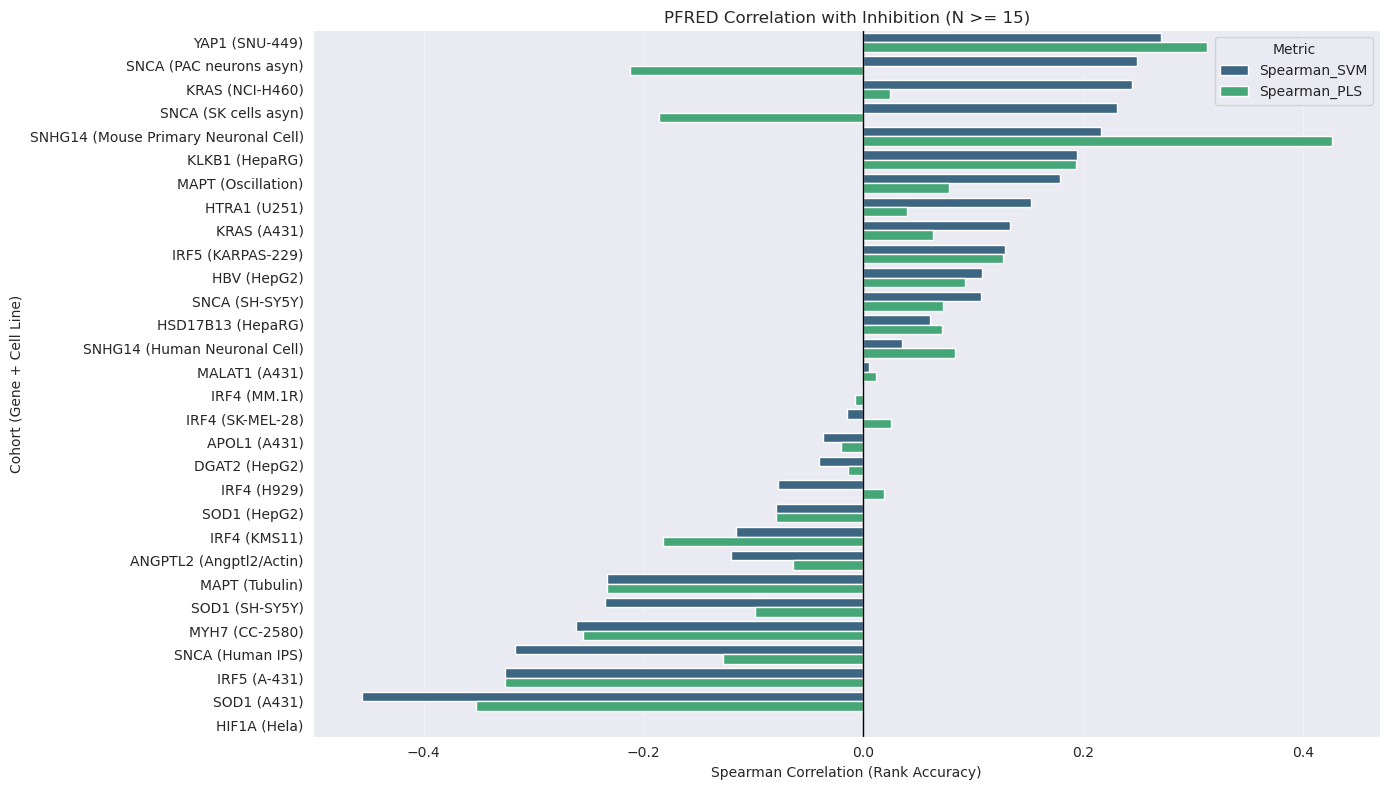

In [78]:
# ==========================================
# PART 2: COHORT ANALYSIS & PLOTTING
# ==========================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from notebooks.consts import CANONICAL_GENE, CELL_LINE

# Config
INPUT_SCORED_CSV = "data_scored_pfred_final.csv" # Updated filename
MIN_COHORT_SIZE = 15  # Minimum N per cohort to calculate correlation

# Ensure CELL_LINE variable is defined (assuming it's a string column name like 'CELL_LINE')
# If it's imported from consts, add it to the import above. Otherwise:

if os.path.exists(INPUT_SCORED_CSV):
    df = pd.read_csv(INPUT_SCORED_CSV, low_memory=False)


    # Ensure columns exist and are numeric
    target_col = 'Inhibition(%)'
    score_cols = ['PFRED_SVM', 'PFRED_PLS'] # Updated column names

    # Check if columns exist before proceeding
    missing_cols = [c for c in score_cols + [target_col, CELL_LINE, CANONICAL_GENE] if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in CSV: {missing_cols}")

    # Clean data for analysis
    for col in [target_col] + score_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows missing critical data
    df_clean = df.dropna(subset=[target_col, CELL_LINE, CANONICAL_GENE] + score_cols)

    # --- CALCULATE CORRELATIONS PER COHORT ---
    cohort_stats = []

    # Group by Cell Line and Gene
    groups = df_clean.groupby([CELL_LINE, CANONICAL_GENE])

    print(f"Analyzing {len(groups)} potential cohorts...")

    for (cell, gene), group in groups:
        if len(group) >= MIN_COHORT_SIZE:
            # Calculate Correlations (Spearman for Ranking)
            spearman_svm = group[target_col].corr(group['PFRED_SVM'], method='spearman')
            spearman_pls = group[target_col].corr(group['PFRED_PLS'], method='spearman')

            cohort_stats.append({
                'Cohort': f"{gene} ({cell})",
                'Gene': gene,
                'Cell_Line': cell,
                'N': len(group),
                'Spearman_SVM': spearman_svm,
                'Spearman_PLS': spearman_pls
            })

    results_df = pd.DataFrame(cohort_stats)

    if not results_df.empty:
        # Sort by SVM performance
        results_df = results_df.sort_values('Spearman_SVM', ascending=False)

        print("\n--- TOP 10 COHORTS (By SVM Correlation) ---")
        print(results_df[['Cohort', 'N', 'Spearman_SVM', 'Spearman_PLS']].head(10))

        # --- PLOTTING ---
        plt.figure(figsize=(14, 8))

        # Reshape for easier plotting with Hue
        plot_data = results_df.melt(
            id_vars=['Cohort', 'N'],
            value_vars=['Spearman_SVM', 'Spearman_PLS'],
            var_name='Metric',
            value_name='Correlation'
        )

        # Create Bar Plot
        # Viridis is good, or 'coolwarm' to show pos/neg contrast
        sns.barplot(data=plot_data, x='Correlation', y='Cohort', hue='Metric', palette='viridis')

        plt.title(f'PFRED Correlation with Inhibition (N >= {MIN_COHORT_SIZE})')
        plt.xlabel('Spearman Correlation (Rank Accuracy)')
        plt.ylabel('Cohort (Gene + Cell Line)')
        plt.axvline(0, color='black', linewidth=1)

        # Add a light grid for readability
        plt.grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.show()

    else:
        print("[WARNING] No cohorts met the minimum size requirement.")
else:
    print(f"[ERROR] Could not find {INPUT_SCORED_CSV}. Run the Mass Scoring Part 1 first.")